# Zillow's Home Value Prediction

###  Zillow:
#### Zillow is an online real estate database company

### Datasets

#### Properties.csv – All the properties with their home features
#### Train.csv – The training set with transactions
#### Zillow_data_dictionary.xlx – Explains all the data fields.


### Zestimate:
#### “Zestimates” are estimated home values based on 7.5 million statistical and machine learning models that analyze hundreds of data points on each property.

### Objective
#### The Main objective of this research project is to use different algorithms to make predictions about the future sale prices of homes, estimations about the home supply in coming years also reduce the error margin and increase the accuracy of Zestimates and eventually, to get an exact valuation of homes.

### Import the necessary modules and files

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
%matplotlib inline
from matplotlib.pylab import plt
%pylab inline

# Make plots larger
plt.rcParams['figure.figsize'] = (15, 9)

prop_df  = pd.read_csv("/content/drive/MyDrive/zillow-prize-1/properties_2017.csv",low_memory = False)
train_df = pd.read_csv("/content/drive/MyDrive/zillow-prize-1/train_2017.csv", parse_dates=["transactiondate"])
#sample_submission = pd.read_csv("sample_submission.csv",low_memory = False)
print(prop_df)



Populating the interactive namespace from numpy and matplotlib
         parcelid  airconditioningtypeid  architecturalstyletypeid  \
0        10754147                    NaN                       NaN   
1        10759547                    NaN                       NaN   
2        10843547                    NaN                       NaN   
3        10859147                    NaN                       NaN   
4        10879947                    NaN                       NaN   
...           ...                    ...                       ...   
2985212  12170430                    NaN                       NaN   
2985213  11422430                    NaN                       NaN   
2985214  17203030                    NaN                       NaN   
2985215  14242830                    NaN                       NaN   
2985216  12766630                    NaN                       NaN   

         basementsqft  bathroomcnt  bedroomcnt  buildingclasstypeid  \
0                 NaN    

In [3]:
print(train_df)

       parcelid  logerror transactiondate
0      14297519  0.025595      2017-01-01
1      17052889  0.055619      2017-01-01
2      14186244  0.005383      2017-01-01
3      12177905 -0.103410      2017-01-01
4      10887214  0.006940      2017-01-01
...         ...       ...             ...
77608  10833991 -0.002245      2017-09-20
77609  11000655  0.020615      2017-09-20
77610  17239384  0.013209      2017-09-21
77611  12773139  0.037129      2017-09-21
77612  12826780  0.007204      2017-09-25

[77613 rows x 3 columns]


#### Target variable is logerror.
##### Logerror is the difference log(Zestimate) and log(Salesprice)

###### Some analysis performed on log error.
##### Scatter plot - a graph in which the values of two variables are plotted along two axes, the pattern of the resulting points revealing any correlation present.

##### A graph is plotted in which the values of two variables are plotted along two axes;x-axis is index, y-axis is logerror;


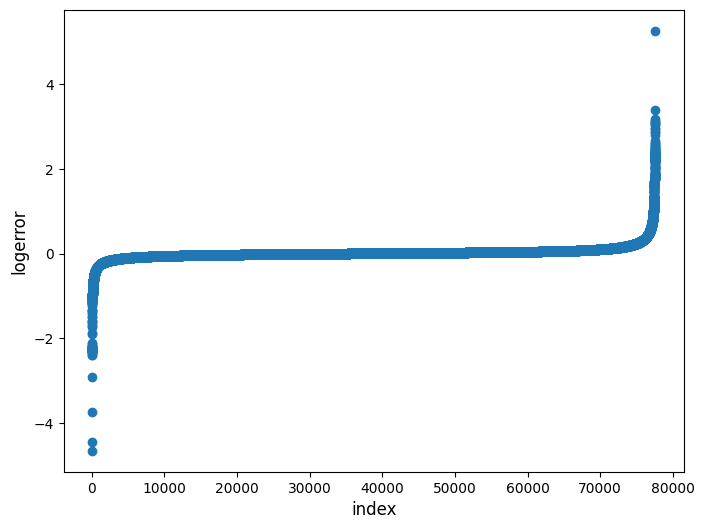

In [4]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df.logerror.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.show()

 ##### There are some outliers at both the ends.

##### Remove the outliers and then plot histogram plot on the same.
##### Range of logerrors

<ipython-input-5-2bab7461e993>:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  train_df['logerror'].loc[train_df['logerror']>ulimit] = ulimit
<ipython-input-5-2bab7461e993>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy o

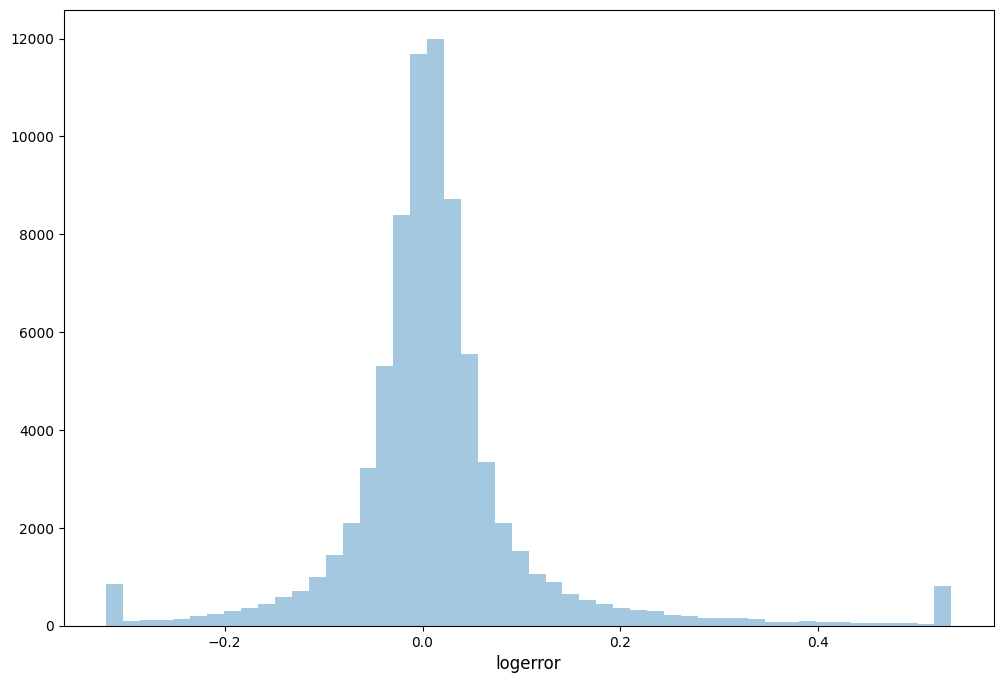

In [5]:
ulimit = np.percentile(train_df.logerror.values, 99)
llimit = np.percentile(train_df.logerror.values, 1)
train_df['logerror'].loc[train_df['logerror']>ulimit] = ulimit
train_df['logerror'].loc[train_df['logerror']<llimit] = llimit

plt.figure(figsize=(12,8))
sns.distplot(train_df.logerror.values, bins=50, kde=False)
plt.xlabel('logerror', fontsize=12)
plt.show()
pd.options.mode.chained_assignment= None

##### A nice normal distribution on the log error.

#### Transaction Date:
##### Check the number of transactions in each month.

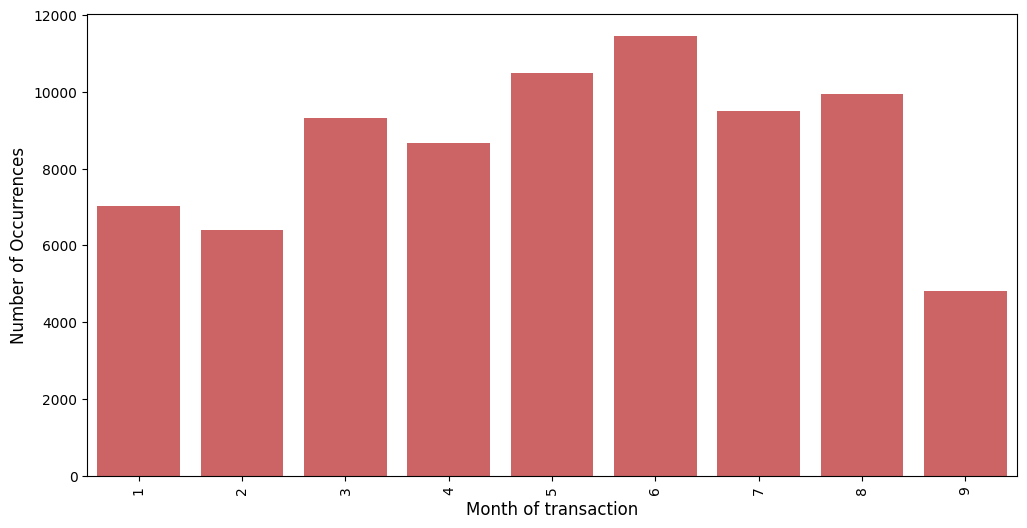

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

color = sns.color_palette()
train_df['transaction_month'] = train_df['transactiondate'].dt.month

cnt_srs = train_df['transaction_month'].value_counts()
plt.figure(figsize=(12, 6))

# Corrected barplot call with x and y arguments
sns.barplot(x=cnt_srs.index, y=cnt_srs.values, alpha=0.8, color=color[3])

plt.xticks(rotation='vertical')
plt.xlabel('Month of transaction', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.show()

##### The train data has all the transactions before September 25, 2017 and no data of the transactions after September 25, 2017.

#### NaN values in properties2017 data

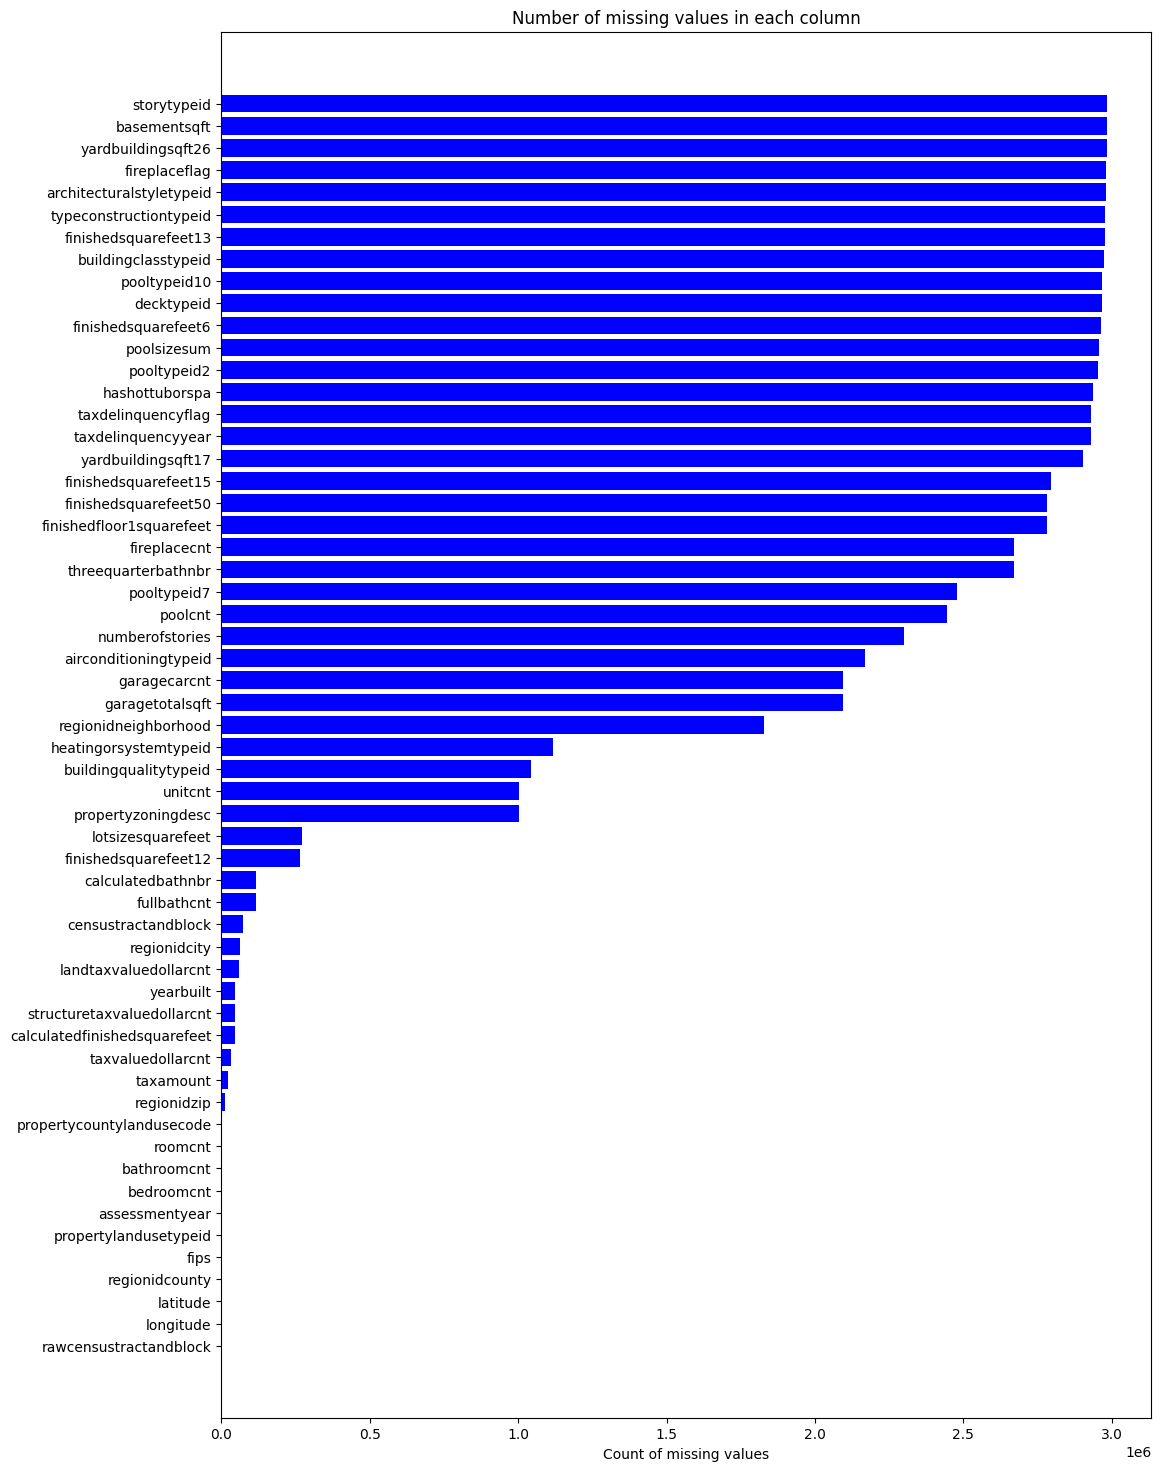

In [7]:
missing_df = prop_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

##### The above plot gives the number of missing values in each column.

## Sale area for Zillow market in 2017

### Joint Plot

#### A marginal plot allows to study the relationship between 2 numeric variables. The central chart display their correlation. It is usually a scatterplot, a hexbin plot, a 2D histogram or a 2D density plot.. The seaborn library provides a joint plot function that is really handy to make this type of graphic.

<Figure size 1200x1200 with 0 Axes>

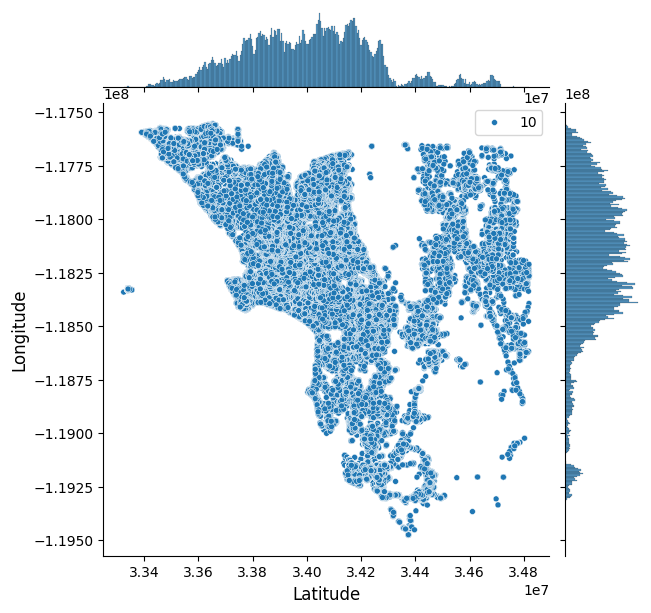

In [8]:
plt.figure(figsize=(12,12))
sns.jointplot(x=prop_df.latitude.values, y=prop_df.longitude.values, size=10)
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.show()

#### From the data page, we are provided with a full list of real estate properties in three counties
#### (Los Angeles, Orange and Ventura, California) data.

### Merging transactions and properties with parcelid as the common field.

In [9]:
train_df = pd.merge(train_df, prop_df, on='parcelid', how='left')
train_df.head()

parcelid  logerror transactiondate  transaction_month  \
0  14297519  0.025595      2017-01-01                  1   
1  17052889  0.055619      2017-01-01                  1   
2  14186244  0.005383      2017-01-01                  1   
3  12177905 -0.103410      2017-01-01                  1   
4  10887214  0.006940      2017-01-01                  1   

   airconditioningtypeid  architecturalstyletypeid  basementsqft  bathroomcnt  \
0                    NaN                       NaN           NaN          3.5   
1                    NaN                       NaN           NaN          1.0   
2                    NaN                       NaN           NaN          2.0   
3                    NaN                       NaN           NaN          3.0   
4                    1.0                       NaN           NaN          3.0   

   bedroomcnt  buildingclasstypeid  ...  numberofstories  fireplaceflag  \
0         4.0                  NaN  ...              NaN            NaN   
1         2.0                  NaN  ...              1.0            NaN   
2         3.0                  NaN  ...              1.0            NaN   
3         4.0                  NaN  ...              NaN            NaN   
4         3.0                  NaN  ...              NaN            NaN   

   structuretaxvaluedollarcnt  taxvaluedollarcnt  assessmentyear  \
0                    485713.0          1023282.0          2016.0   
1                     88000.0           464000.0          2016.0   
2                     85289.0           564778.0          2016.0   
3                    108918.0           145143.0          2016.0   
4                     73681.0           119407.0          2016.0   

   landtaxvaluedollarcnt  taxamount  taxdelinquencyflag  taxdelinquencyyear  \
0               537569.0   11013.72                 NaN                 NaN   
1               376000.0    5672.48                 NaN                 NaN   
2               479489.0    6488.30                 NaN                 NaN   
3                36225.0    1777.51                 NaN                 NaN   
4                45726.0    1533.89                 NaN                 NaN   

   censustractandblock  
0         6.059063e+13  
1         6.111001e+13  
2         6.059022e+13  
3         6.037300e+13  
4         6.037124e+13  

[5 rows x 61 columns]

##### Check the dtypes of different types of variable.

In [10]:
pd.options.display.max_rows = 65

dtype_df = train_df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df

Count     Column Type
0                       parcelid           int64
1                       logerror         float64
2                transactiondate  datetime64[ns]
3              transaction_month           int32
4          airconditioningtypeid         float64
5       architecturalstyletypeid         float64
6                   basementsqft         float64
7                    bathroomcnt         float64
8                     bedroomcnt         float64
9            buildingclasstypeid         float64
10         buildingqualitytypeid         float64
11             calculatedbathnbr         float64
12                    decktypeid         float64
13      finishedfloor1squarefeet         float64
14  calculatedfinishedsquarefeet         float64
15          finishedsquarefeet12         float64
16          finishedsquarefeet13         float64
17          finishedsquarefeet15         float64
18          finishedsquarefeet50         float64
19           finishedsquarefeet6         float64
20                          fips         float64
21                  fireplacecnt         float64
22                   fullbathcnt         float64
23                  garagecarcnt         float64
24               garagetotalsqft         float64
25                hashottuborspa          object
26         heatingorsystemtypeid         float64
27                      latitude         float64
28                     longitude         float64
29             lotsizesquarefeet         float64
30                       poolcnt         float64
31                   poolsizesum         float64
32                  pooltypeid10         float64
33                   pooltypeid2         float64
34                   pooltypeid7         float64
35     propertycountylandusecode          object
36         propertylandusetypeid         float64
37            propertyzoningdesc          object
38        rawcensustractandblock         float64
39                  regionidcity         float64
40                regionidcounty         float64
41          regionidneighborhood         float64
42                   regionidzip         float64
43                       roomcnt         float64
44                   storytypeid         float64
45           threequarterbathnbr         float64
46        typeconstructiontypeid         float64
47                       unitcnt         float64
48            yardbuildingsqft17         float64
49            yardbuildingsqft26         float64
50                     yearbuilt         float64
51               numberofstories         float64
52                 fireplaceflag          object
53    structuretaxvaluedollarcnt         float64
54             taxvaluedollarcnt         float64
55                assessmentyear         float64
56         landtaxvaluedollarcnt         float64
57                     taxamount         float64
58            taxdelinquencyflag          object
59            taxdelinquencyyear         float64
60           censustractandblock         float64

##### Almost all are float variables with few object (categorical) variables

##### Get the count.

In [11]:
dtype_df.groupby("Column Type").aggregate('count').reset_index()

Column Type  Count
0           int64      1
1         float64     53
2  datetime64[ns]      1
3           int32      1
4          object      5

##### Check the number of Nulls in this new merged dataset.

In [12]:
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['missing_ratio'] = missing_df['missing_count'] / train_df.shape[0]
missing_df.loc[missing_df['missing_ratio']>0.999]

column_name  missing_count  missing_ratio
6           basementsqft          77563       0.999356
9    buildingclasstypeid          77598       0.999807
16  finishedsquarefeet13          77571       0.999459
44           storytypeid          77563       0.999356
49    yardbuildingsqft26          77543       0.999098

##### Five columns have missing values 99.9% of the times

#### Univariate Analysis:
##### Take the 'float' variables alone and then get the correlation with the target variable to see how they are related.
##### Impute the missing values with mean values to compute correlation coefficients

##### Correlation coefficient

###### A number between −1 and +1 calculated so as to represent the linear dependence of two variables or sets of data.

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


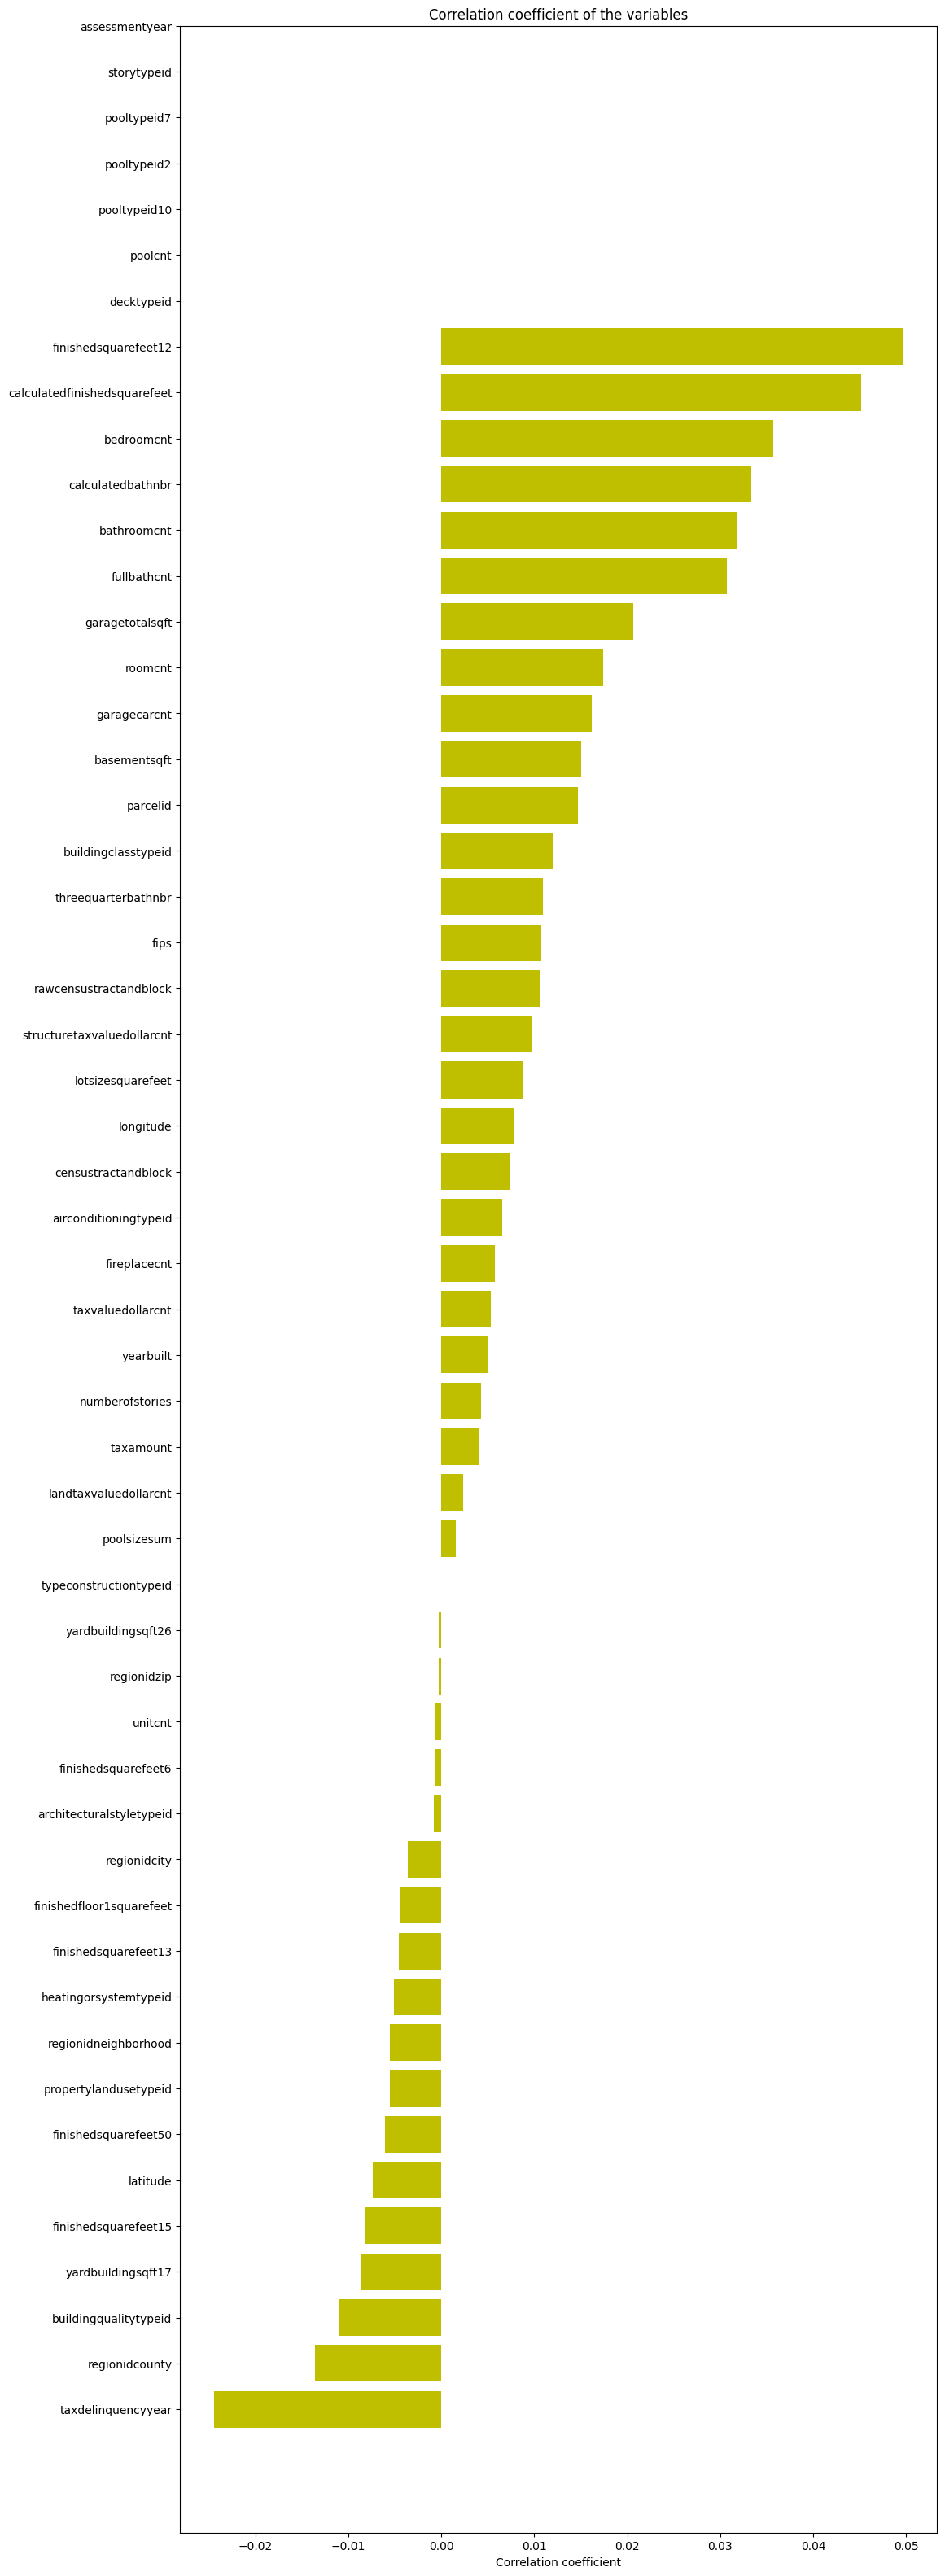

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [13]:
numeric_columns = train_df.select_dtypes(include=['float64', 'int64']).columns
mean_values = train_df[numeric_columns].mean(axis=0)
train_df_new = train_df.fillna(mean_values)

# Calculate correlation coefficients for each of these variables
x_cols = [col for col in train_df_new.columns if col != 'logerror' and train_df_new[col].dtype in ['float64', 'int64']]

labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(train_df_new[col].values, train_df_new['logerror'].values)[0, 1])

corr_df = pd.DataFrame({'col_labels': labels, 'corr_values': values})
corr_df = corr_df.sort_values(by='corr_values')

# Plot the correlation coefficients
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(12, 40))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='y')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")

plt.show()

# Set numpy error handling to ignore division and invalid operations
np.seterr(divide='ignore', invalid='ignore')

##### The correlation of the target variable with the given set of variables are low overall.

##### There are few variables at the top of this graph without any correlation values. I guess they have only one unique value and hence no correlation value. Let us confirm the same.

In [14]:
corr_zero_cols = ['assessmentyear', 'storytypeid', 'pooltypeid2', 'pooltypeid7', 'pooltypeid10', 'poolcnt', 'decktypeid']
for col in corr_zero_cols:
    print(col, len(train_df_new[col].unique()))

assessmentyear 1
storytypeid 1
pooltypeid2 1
pooltypeid7 1
pooltypeid10 1
poolcnt 1
decktypeid 1


##### Let us take the variables with high correlation values and then do some analysis on them

In [15]:
corr_df_sel = corr_df.loc[(corr_df['corr_values']>0.02) | (corr_df['corr_values'] < -0.01)]
corr_df_sel

col_labels  corr_values
51            taxdelinquencyyear    -0.024390
34                regionidcounty    -0.013535
7          buildingqualitytypeid    -0.011012
21               garagetotalsqft     0.020631
19                   fullbathcnt     0.030747
4                    bathroomcnt     0.031800
8              calculatedbathnbr     0.033346
5                     bedroomcnt     0.035700
11  calculatedfinishedsquarefeet     0.045126
12          finishedsquarefeet12     0.049621

#### Draw the heatmap using seaborn

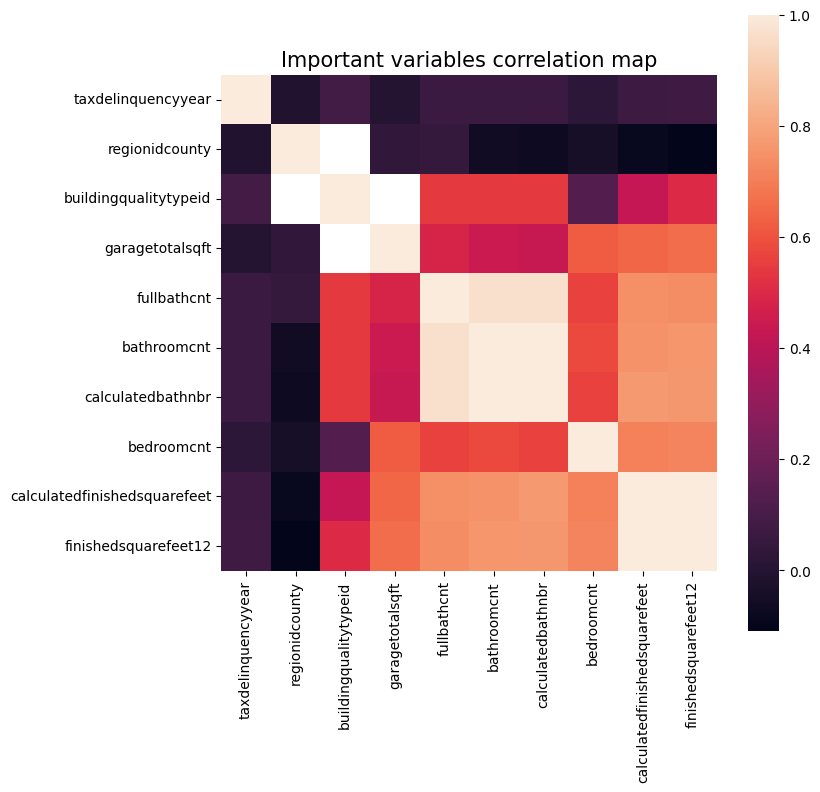

In [16]:
cols_to_use = corr_df_sel.col_labels.tolist()

temp_df = train_df[cols_to_use]
corrmat = temp_df.corr(method='spearman')
f, ax = plt.subplots(figsize=(8, 8))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=1., square=True)
plt.title("Important variables correlation map", fontsize=15)
plt.show()

##### There is a value of 2.298 in the bathroom count. This is the mean value

##### The important variables themselves are very highly correlated.

#### Finished SquareFeet 12: FInished Living Area

##### Find how the finished square feet 12 varies with the log error.

<ipython-input-17-7d4ae06359dd>:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  train_df[col].loc[train_df[col]>ulimit] = ulimit
<ipython-input-17-7d4ae06359dd>:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!


<Figure size 1200x1200 with 0 Axes>

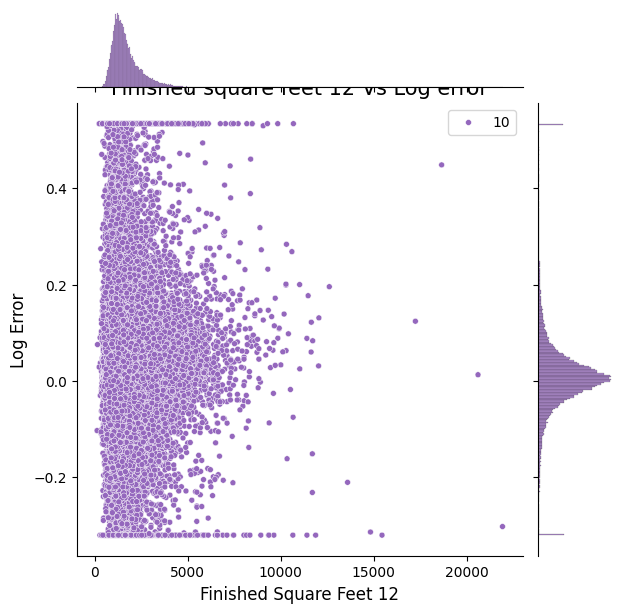

In [17]:
col = "finishedsquarefeet12"
ulimit = np.percentile(train_df[col].values, 99.5)
llimit = np.percentile(train_df[col].values, 0.5)
train_df[col].loc[train_df[col]>ulimit] = ulimit
train_df[col].loc[train_df[col]<llimit] = llimit

plt.figure(figsize=(12,12))
sns.jointplot(x=train_df.finishedsquarefeet12.values, y=train_df.logerror.values, size=10, color=color[4])
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Finished Square Feet 12', fontsize=12)
plt.title("Finished square feet 12 Vs Log error", fontsize=15)
plt.show()

##### Range of logerror narrows down with increase in finished square feet 12 variable.
##### We can conclude that large house value is easy to predict

#### Calculated finished square feet: Calculated total finished living area of the home.

<ipython-input-18-7b669beda412>:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  train_df[col].loc[train_df[col]>ulimit] = ulimit
<ipython-input-18-7b669beda412>:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!


<Figure size 1200x1200 with 0 Axes>

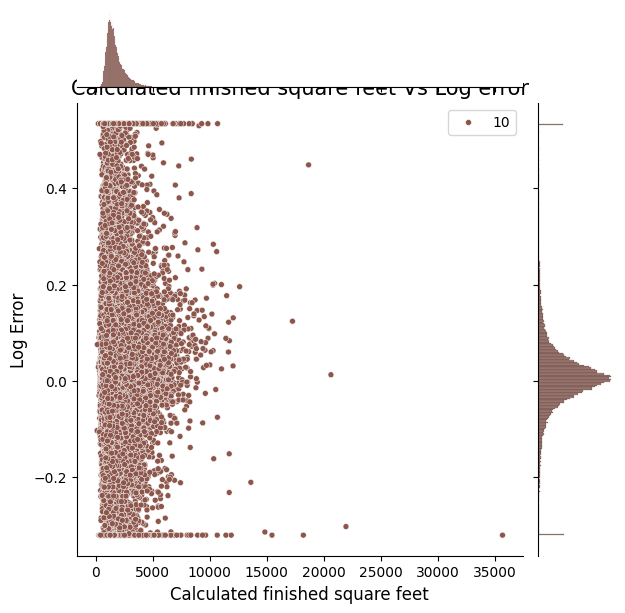

In [18]:
col = "calculatedfinishedsquarefeet"
ulimit = np.percentile(train_df[col].values, 99.5)
llimit = np.percentile(train_df[col].values, 0.5)
train_df[col].loc[train_df[col]>ulimit] = ulimit
train_df[col].loc[train_df[col]<llimit] = llimit

plt.figure(figsize=(12,12))
sns.jointplot(x=train_df.calculatedfinishedsquarefeet.values, y=train_df.logerror.values, size=10, color=color[5])
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Calculated finished square feet', fontsize=12)
plt.title("Calculated finished square feet Vs Log error", fontsize=15)
plt.show()

##### Calculated finished square feet and finishedsquarefeet12 are highly related to each other, hence the distribution is similar.

#### Bathroom Count

##### A count plot is plotted

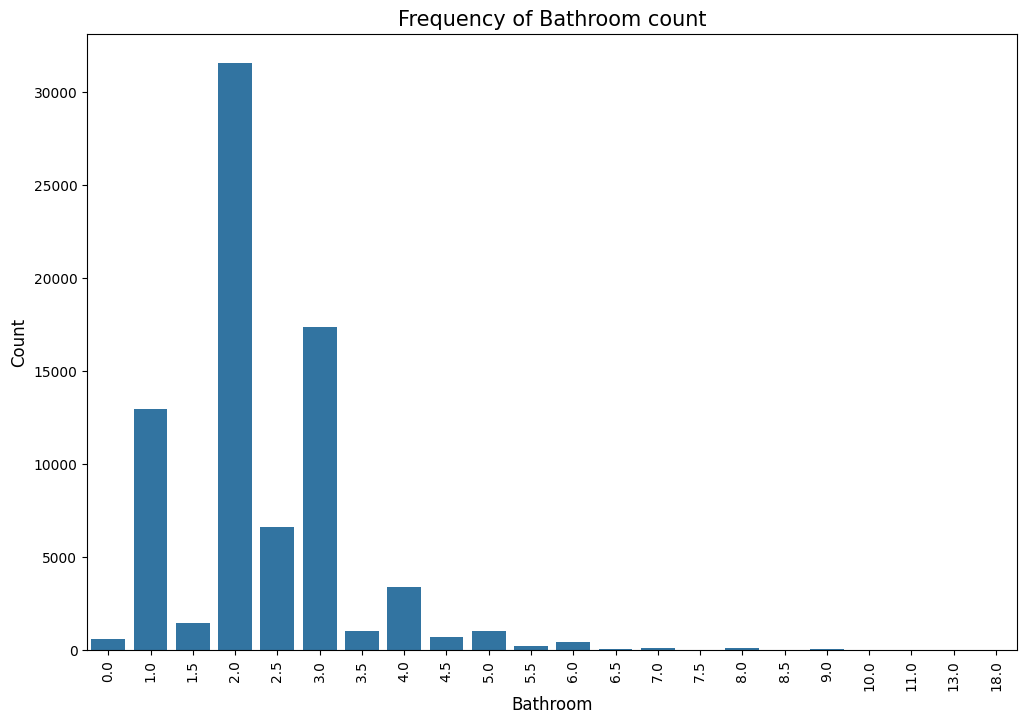

In [19]:
plt.figure(figsize=(12,8))
sns.countplot(x="bathroomcnt", data=train_df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Bathroom', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Bathroom count", fontsize=15)
plt.show()

##### Relation of bathroom count with logerror

#### Plot a boxplot for bathroom count and logerror

###### Boxplot

###### It is a standardized way of displaying the distribution of data based on the five number summary: minimum, first quartile, median, third quartile, and maximum.

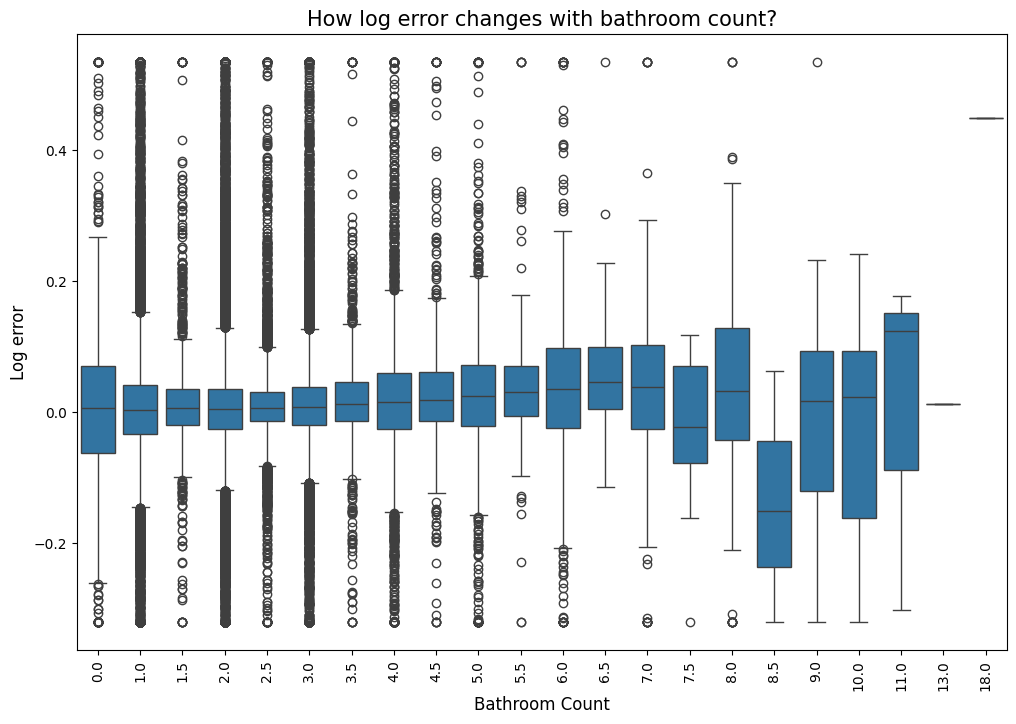

In [20]:
plt.figure(figsize=(12,8))
sns.boxplot(x="bathroomcnt", y="logerror", data=train_df)
plt.ylabel('Log error', fontsize=12)
plt.xlabel('Bathroom Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("How log error changes with bathroom count?", fontsize=15)
plt.show()

#### Bedroom count:

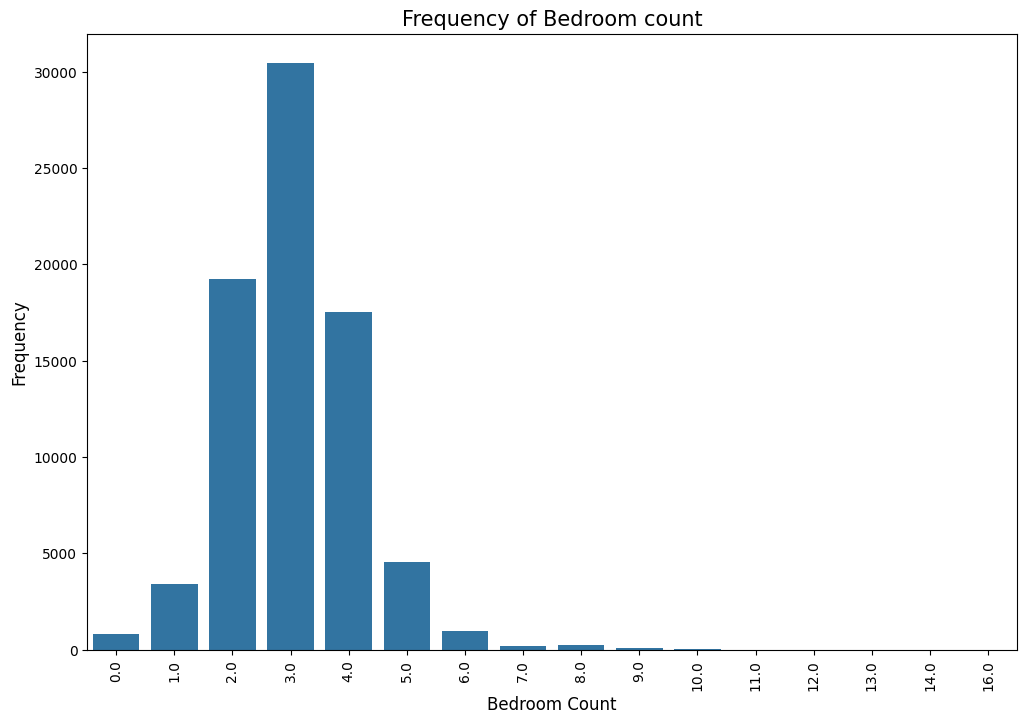

In [21]:
plt.figure(figsize=(12,8))
sns.countplot(x="bedroomcnt", data=train_df)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Bedroom Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Bedroom count", fontsize=15)
plt.show()

#### 3.05 is the mean value with which is replaced the Null values.

#### Violin Plot

##### A violin plot is a method of plotting numeric data. It is similar to box plot with a rotated kernel density plot on each side. A violin plot has four layers.

<ipython-input-22-6c09d62002ac>:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  train_df['bedroomcnt'].loc[train_df['bedroomcnt']>7] = 7


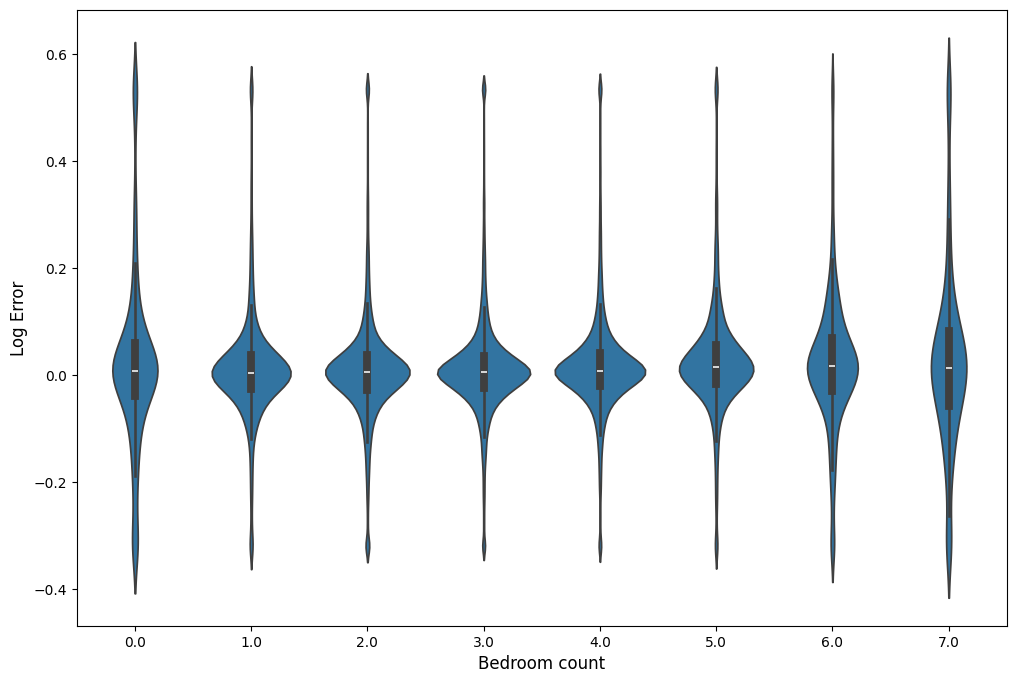

In [22]:
train_df['bedroomcnt'].loc[train_df['bedroomcnt']>7] = 7
plt.figure(figsize=(12,8))
sns.violinplot(x='bedroomcnt', y='logerror', data=train_df)
plt.xlabel('Bedroom count', fontsize=12)
plt.ylabel('Log Error', fontsize=12)
plt.show()

#### Taxamount : The total property tax assessed for that assessment year.

<ipython-input-23-3088c0a18b1c>:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  train_df[col].loc[train_df[col]>ulimit] = ulimit
<ipython-input-23-3088c0a18b1c>:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!


<Figure size 1200x1200 with 0 Axes>

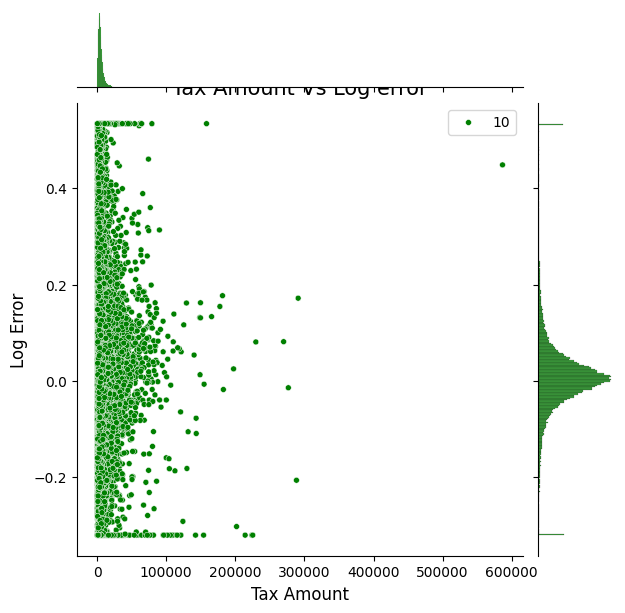

In [23]:
col = "taxamount"
ulimit = np.percentile(train_df[col].values, 99.5)
llimit = np.percentile(train_df[col].values, 0.5)
train_df[col].loc[train_df[col]>ulimit] = ulimit
train_df[col].loc[train_df[col]<llimit] = llimit

plt.figure(figsize=(12,12))
sns.jointplot(x=train_df['taxamount'].values, y=train_df['logerror'].values, size=10, color='g')
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Tax Amount', fontsize=12)
plt.title("Tax Amount Vs Log error", fontsize=15)
plt.show()

#### Range of logerror narrows down with increase in tax Amount variable.

# Clustering Analysis

Cluster the data to bring out the underlying structural similarities within our data.

####  regionidcounty - county in which the property is located
#### regionidzip - zip code in which the property is located
#### bathroomcnt - number of bathrooms in home including fractional bathrooms
#### propertylandusetypeid - type of land used the property is zoned for

#### Principal component analysis (PCA) is probably the most popular multivariate statistical technique and it is used by almost all scientific disciplines. It is also likely to be the oldest multivariate technique.

##### Fill the missing values with mode values

In [24]:
distance_columns = ['latitude', 'longitude', 'bathroomcnt', 'regionidcounty', 'regionidzip', 'propertylandusetypeid']
total_data = train_df[distance_columns]
total_data = total_data.dropna(how='all')
total_data['regionidzip'] = total_data['regionidzip'].fillna(total_data['regionidzip'].mode()[0])
total_data.head()

latitude    longitude  bathroomcnt  regionidcounty  regionidzip  \
0  33634931.0 -117869207.0          3.5          1286.0      96978.0   
1  34449266.0 -119281531.0          1.0          2061.0      97099.0   
2  33886168.0 -117823170.0          2.0          1286.0      97078.0   
3  34245180.0 -118240722.0          3.0          3101.0      96330.0   
4  34185120.0 -118414640.0          3.0          3101.0      96451.0   

   propertylandusetypeid  
0                  261.0  
1                  261.0  
2                  261.0  
3                  261.0  
4                  266.0

### PCA is a method used to reduce number of variables in your data by extracting important one from a large pool. It reduces the dimension of your data with the aim of retaining as much information as possible.

### K-means clustering

#### The goal of this algorithm is to find groups in the data, with the number of groups represented by the variable K. The algorithm works iteratively to assign each data point to one of K groups based on the features that are provided. Data points are clustered based on feature similarity. The results of the K-means clustering algorithm are:

#### The centroids of the K clusters, which can be used to label new data
#### Labels for the training data (each data point is assigned to a single cluster)

In [25]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
reduced_data = PCA(n_components=2).fit_transform(total_data)
kmeans = KMeans(n_clusters=10, random_state=0).fit(reduced_data)
labels = kmeans.predict(reduced_data)
total_data.loc[:, 'label'] = labels
centroids = kmeans.cluster_centers_

##### Perform K-means clustering based on Zipcode.

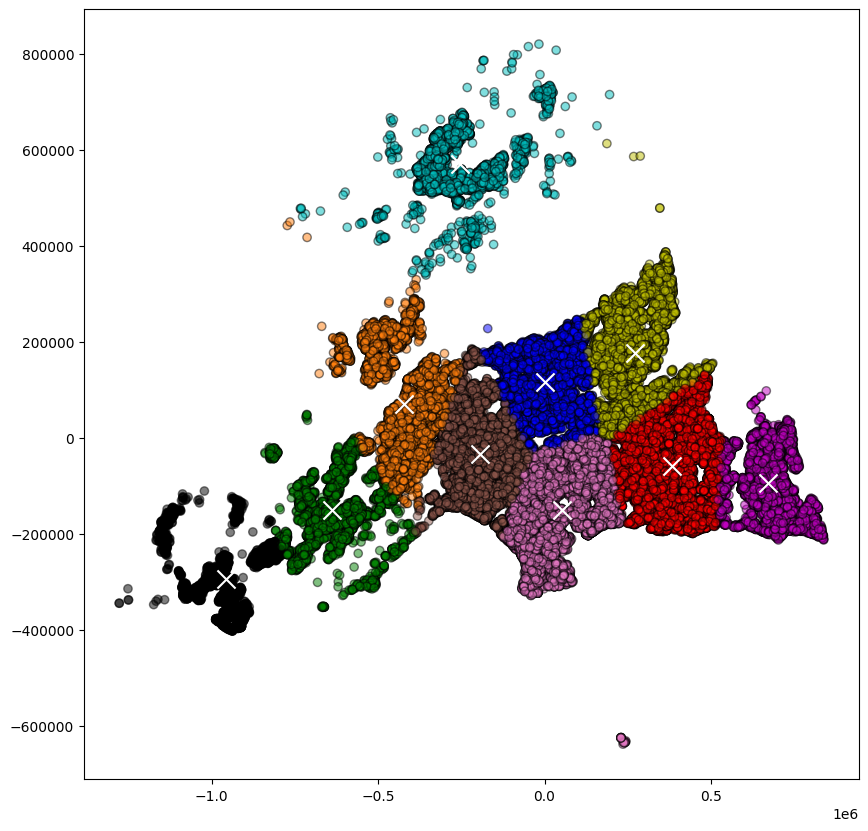

In [26]:
fig = plt.figure(figsize=(10, 10))
colmap = {1: 'r', 2: 'g', 3: 'b', 4: 'c', 5: 'm', 6: 'y',7:'k',8:'tab:orange',9:'tab:brown',10:'tab:pink'}

# colors = map(lambda x: colmap[x+1], labels)
colors = [colmap[x+1] for x in labels]
plt.scatter(reduced_data[:,0], reduced_data[:,1], c=colors, alpha=0.5, edgecolor='k')
for idx, centroid in enumerate(centroids):
    plt.scatter(*centroid, c='w', marker='x',zorder=10, s=170)
plt.show()

##### Nice and uniform distribution of clusters with outliers which can be removed for better modelling results.


#### Geographical features and property specific features are common in many properties which might help us to determine structural patterns and similarities in the data.


## Random Forest Regressor

#### The random forest model is a type of additive model that makes predictions by combining decisions from a sequence of base models. More formally we can write this class of models as:

#### g(x)=f0(x)+f1(x)+f2(x)+...
#### where the final model g is the sum of simple base models fi. Here, each base classifier is a simple decision tree. This broad technique of using multiple models to obtain better predictive performance is called model ensembling. In random forests, all the base models are constructed independently using a different subsample of the data.

#### What is cross validation?

#### Cross-validation is a technique to evaluate predictive models by partitioning the original sample into a training set to train the model, and a test set to evaluate it.

In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score


#### Reading Training Data

In [28]:
#Reading Training Data
dftrain = pd.read_csv('/content/drive/MyDrive/zillow-prize-1/train_2017.csv')
dfprop = pd.read_csv('/content/drive/MyDrive/zillow-prize-1/properties_2017.csv',low_memory = False)



In [29]:
#Filling missing values with -1
dfprop.fillna(-1,inplace=True)



In [30]:
#Merging Datafiles
df = pd.merge(dftrain, dfprop, on='parcelid', suffixes=('', '_r'))

#Dropping meta columns and casting to accepted dtypes
X = df.drop(['parcelid', 'logerror', 'transactiondate',
             'propertyzoningdesc', 'propertycountylandusecode'], axis=1)
for c in ['hashottuborspa', 'fireplaceflag', 'taxdelinquencyflag']:
    X[c] = X[c].astype('bool')



### Applying RandomForestRegressor

In [31]:
clf = RandomForestRegressor(n_estimators=50)
scores = cross_val_score(clf, X, df.logerror, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

print("%s Accuracy: %0.5f" % (clf.__class__.__name__, scores.mean()))
print('--------------------------------------------------')


RandomForestRegressor Accuracy: -0.07873
--------------------------------------------------


In [32]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization
import seaborn as sns
#import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor;

### Set plot parameters

In [33]:
# Set plot parameters
from IPython.display import set_matplotlib_formats

plt.rcParams['savefig.dpi'] = 300

%matplotlib inline
### Seaborn style
sns.set_style("whitegrid")

#### Read the input data

In [35]:
prop = pd.read_csv("/content/drive/MyDrive/zillow-prize-1/properties_2017.csv", low_memory=False)
prop.shape;

### calculate the percent missing values(NaN)

In [36]:
# calculate the percent missing values(NaN)
nan = prop.isnull().sum()/len(prop)*100

#### Plotting NaN counts

In [37]:
### Plotting NaN counts
nan_sorted = nan.sort_values(ascending=False).to_frame().reset_index()
nan_sorted.columns = ['Column', 'percentNaN']
nan_sorted.head();

### Get the train data

In [39]:
train = pd.read_csv("/content/drive/MyDrive/zillow-prize-1/train_2017.csv", parse_dates=["transactiondate"])

### Sort the transaction date in ascending order

In [40]:
train['transaction_month'] = pd.DatetimeIndex(train['transactiondate']).month
train.sort_values('transaction_month', axis=0, ascending=True, inplace=True)

### Merge the train and properties datasets

In [41]:
# merge the train and properties datasets
train = pd.merge(train, prop, on='parcelid', how='left')

### Impute the missing values with median values to compute the importance scores

In [43]:
# Select only numeric columns for median imputation
numeric_columns = train.select_dtypes(include=['float64', 'int64']).columns

# Impute missing values with median for numeric columns
median_values_train = train[numeric_columns].median(axis=0)
train[numeric_columns] = train[numeric_columns].fillna(median_values_train)

###  Label Encoder

####  Label encoding refers to transforming the word labels into numerical form so that the algorithms can understand how to operate on them.

In [44]:
for c in train[['transactiondate', 'hashottuborspa', 'propertycountylandusecode', 'propertyzoningdesc', 'fireplaceflag', 'taxdelinquencyflag']]:
    label = LabelEncoder()
    label.fit(list(train[c].values))
    train[c] = label.transform(list(train[c].values))

x_train = train.drop(['parcelid', 'logerror', 'transactiondate'], axis=1)
y_train = train['logerror']

### Apply Random Forest Regressor

#### Random forests are among the most popular machine learning methods thanks to their relatively good accuracy, robustness and ease of use. They also provide two straightforward methods for feature selection: mean decrease impurity and mean decrease accuracy.

In [45]:
rf = RandomForestRegressor(n_estimators=30, max_features=None)
rf.fit(x_train, y_train);

#### Calculate the feature importance

In [46]:
rf_importance = rf.feature_importances_
rf_importance_df = pd.DataFrame()
rf_importance_df['features'] = x_train.columns
rf_importance_df['importance'] = rf_importance
rf_importance_df.head();

#### Sort the values

In [47]:
rf_importance_df.sort_values('importance', axis=0, inplace=True, ascending=False)

rf_importance_df_trim = rf_importance_df[rf_importance_df.importance>0.001]

rf_importance_df_trim.tail()

rf_feature_list = rf_importance_df_trim.features

####  Plot a barplot to list the important features

In [48]:
fig, ax = plt.subplots(figsize=(48, 100), dpi=300)
sns.set_context("poster", font_scale=6)
# [1]
sns.barplot(x="importance", y="features", data=rf_importance_df, color='Green', ax=ax)
ax.set(xlabel="Importance (Variance explained)", ylabel="")
ax.set_title('Random Forest Importance', fontsize= 96)
plt.show()

#### Applied Random Forest Regressor to determine which features of the dataset are most important.
#### Using these features, we would be able to carry out further predictions.  


#### Top five important features got as a result of Random Forest Regressor

#### 1. Latitude
#### 2. Lotsizesquarefeet - Area of the lot in square feet
#### 3. Structuretaxvalueddollarcnt - The assessed value of the built structure on the parcel
#### 4. Calculatedfinishedsquarefeet -  Calculated total finished living area of the home
#### 5. Longitude


### SUMMARY

##### The output variable logerror has relation with the finished living area, tax amount. As the living area goes on increasing, the log error goes on decreasing and this means that Zestimate has predicted accurately.
##### Also when we performed analysis of tax amount on a particular property in an assessment year with respect to the log error, we observed that Zestimate is more closer to the SalePrice when the value of tax is more, which means that the log error is comparatively less. Using clustering analysis based on zip code, we understood the zillow market. Geographical features and property specific features are common in many properties which might help us to determine structural patterns and similarities in the data.
##### Using random forest regressor, we ranked the most important features for making further analysis.